# Project: ML Experiment Outcome Predictor

This notebook simulates machine learning experiments with various hyperparameters and the goal is to:
- Predict whether the experiment will **succeed** (classification)
- Predict the final **model accuracy** (regression)

It demonstrates synthetic data generation, exploratory data analysis (EDA), and classification/regression modeling.

## Phase 1: Simulate the Dataset

1. Use **NumPy** and **Pandas** to randomly generate hyperparameters for 1000 synthetic ML experiments.
2. Define a mathematical formula to calculate:
   - **Success Probability** (binary outcome)
   - **Final Accuracy** (continuous outcome)
3. Add controlled noise to make the data more realistic, simulating real-world unpredictability.

In [1]:
#Generating synthetic data
import numpy as np
import pandas as pd

n_samples = 1000 #number of ML experiments

#Hyperparamets generation
learning_rate = np.random.uniform(0.0001, 0.2, n_samples) 
num_layers = np.random.randint(1, 6, n_samples) 
batch_size = np.random.choice([16, 32, 64, 128], n_samples)
dropout = np.round(np.random.uniform(0.0, 0.5, n_samples), 2) 

In [2]:
#Generating logic for success probability 
success_prob = (
    0.75
    - 1.3 * learning_rate
    + 0.12 * num_layers
    - 0.6 * dropout
    - 0.6 * (((batch_size - 16) / (128 - 16) - 0.5) ** 2)
)

success_prob += np.random.normal(0, 0.1, n_samples) #adding noise
success_prob = np.clip(success_prob, 0, 1)
success = (np.random.rand(n_samples) < success_prob).astype(int)

## Generating accuracy based on success
accuracy = (
    0.55
    + 0.25 * (1 - dropout)
    + 0.10 * (num_layers / 5)
    - 0.30 * learning_rate
    - 0.12 * (((batch_size - 16) / (128 - 16) - 0.5) ** 2)
)
accuracy += np.random.normal(0, 0.02, n_samples)
accuracy = np.clip(accuracy, 0, 1)
accuracy = np.round(accuracy, 3)

data = {
    'learning_rate': learning_rate,
    'num_layers': num_layers,
    'batch_size': batch_size,
    'dropout': dropout,
    'success': success,
    'accuracy': accuracy
}

df = pd.DataFrame(data)
df.head(20) #print first 20 rows

,learning_rate,num_layers,batch_size,dropout,success,accuracy
0,0.044796,5,32,0.27,1,0.791
1,0.160643,1,32,0.03,0,0.727
2,0.019306,5,16,0.45,1,0.763
3,0.113018,2,128,0.09,1,0.773
4,0.099347,2,64,0.47,0,0.717
5,0.184320,5,64,0.18,1,0.809
6,0.173174,3,16,0.23,0,0.747
7,0.104990,1,64,0.46,1,0.714
8,0.189582,3,64,0.13,1,0.809
9,0.156176,1,128,0.23,0,0.671


In [3]:
df['success'].value_counts(normalize=True)

success
1    0.742
0    0.258
Name: proportion, dtype: float64


---

## Phase 2: Visual Analysis of the Simulated Data

Here, we explore how each hyperparameter correlates with:
- **Binary success (`0` or `1`)**
- **Final accuracy (continuous)**

We use:
- Histograms for distribution
- Boxplots for correlation with success
- Lineplots for trends with accuracy

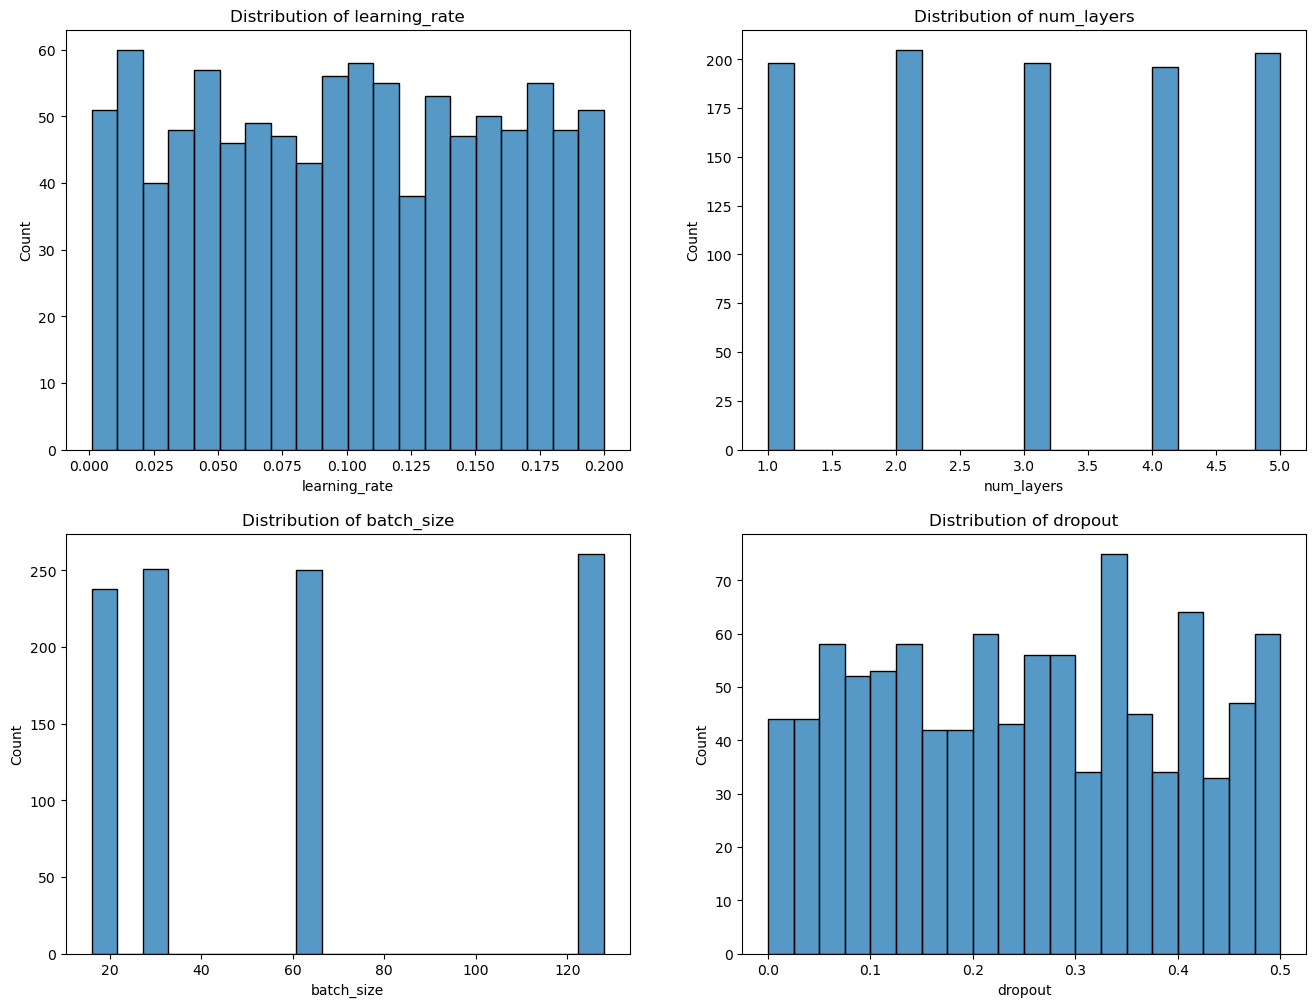

In [4]:
#EDA
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16, 12))

for i, col in enumerate(['learning_rate', 'num_layers', 'batch_size', 'dropout']):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], kde=False, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

---
## Success vs Hyperparameter Distributions

Here we compare how each hyperparameter behaves in **successful (success = 1)** vs **failed (success = 0)** experiments using boxplots.

This helps us understand which hyperparameters influence experiment outcomes, and whether there are distinct patterns associated with success.

### 🔍 What to look for:
- **learning_rate**: Does success prefer lower rates?
- **num_layers**: Do deeper models succeed more?
- **dropout**: Is too much dropout linked to failure?
- **batch_size**: Is there a sweet spot (like 32 or 64) for success?

> A boxplot shows the spread and median of each group.  
> If the two boxes (success = 0 and 1) are very different, it means that hyperparameter is highly predictive of success.

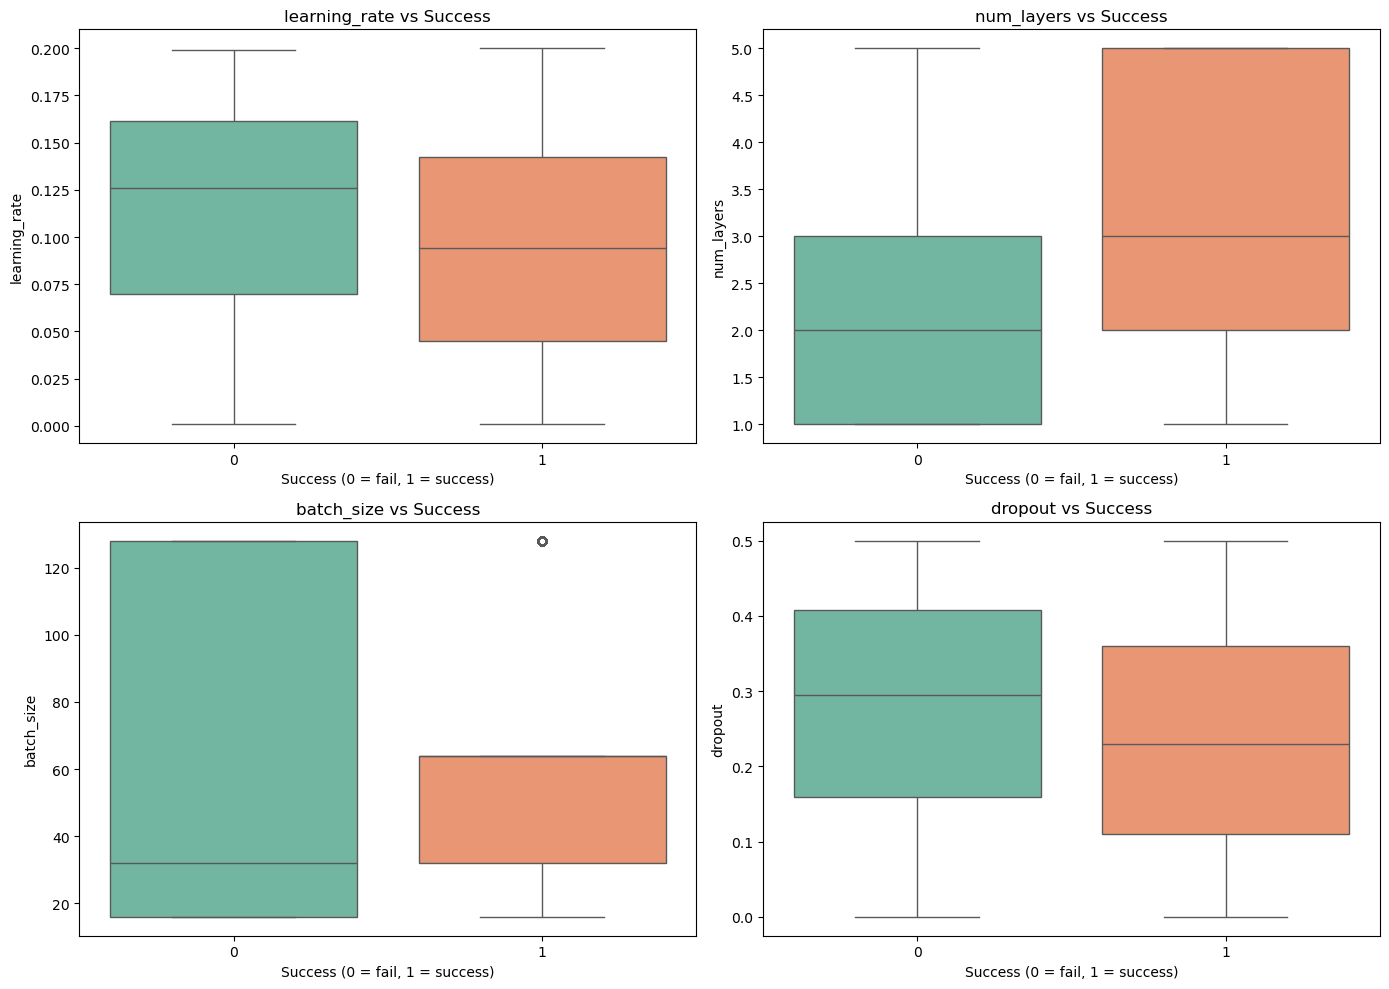

In [5]:
plt.figure(figsize=(14, 10))

features = ['learning_rate', 'num_layers', 'batch_size', 'dropout']

for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='success', y=col, hue='success', data=df, palette='Set2', legend=False)
    plt.title(f'{col} vs Success')
    plt.xlabel('Success (0 = fail, 1 = success)')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

## 📌 Observations — Success vs Hyperparameters

- **Learning Rate**: Successful experiments tend to use slightly lower learning rates (~0.05–0.1), while failed ones skew higher. This aligns with common ML wisdom that too-high learning rates destabilize training.

- **Num Layers**: Experiments with more layers (3–5) are significantly more likely to succeed. Shallower networks (1–2 layers) fail more often, possibly due to underfitting or insufficient capacity.

- **Dropout**: Moderate dropout (around 0.1–0.3) is associated with success. Higher dropout rates (~0.3–0.5) tend to reduce the chance of success, suggesting excessive regularization harms performance.

- **Batch Size**: Successful experiments are concentrated around batch sizes of 32–64. Extremely small (16) or large (128) batch sizes are more frequent in failed runs, forming a U-shaped pattern of risk.

---
### 🔍 Accuracy vs Hyperparameters

We plot how accuracy changes as each hyperparameter changes. This helps us identify which features are most predictive.

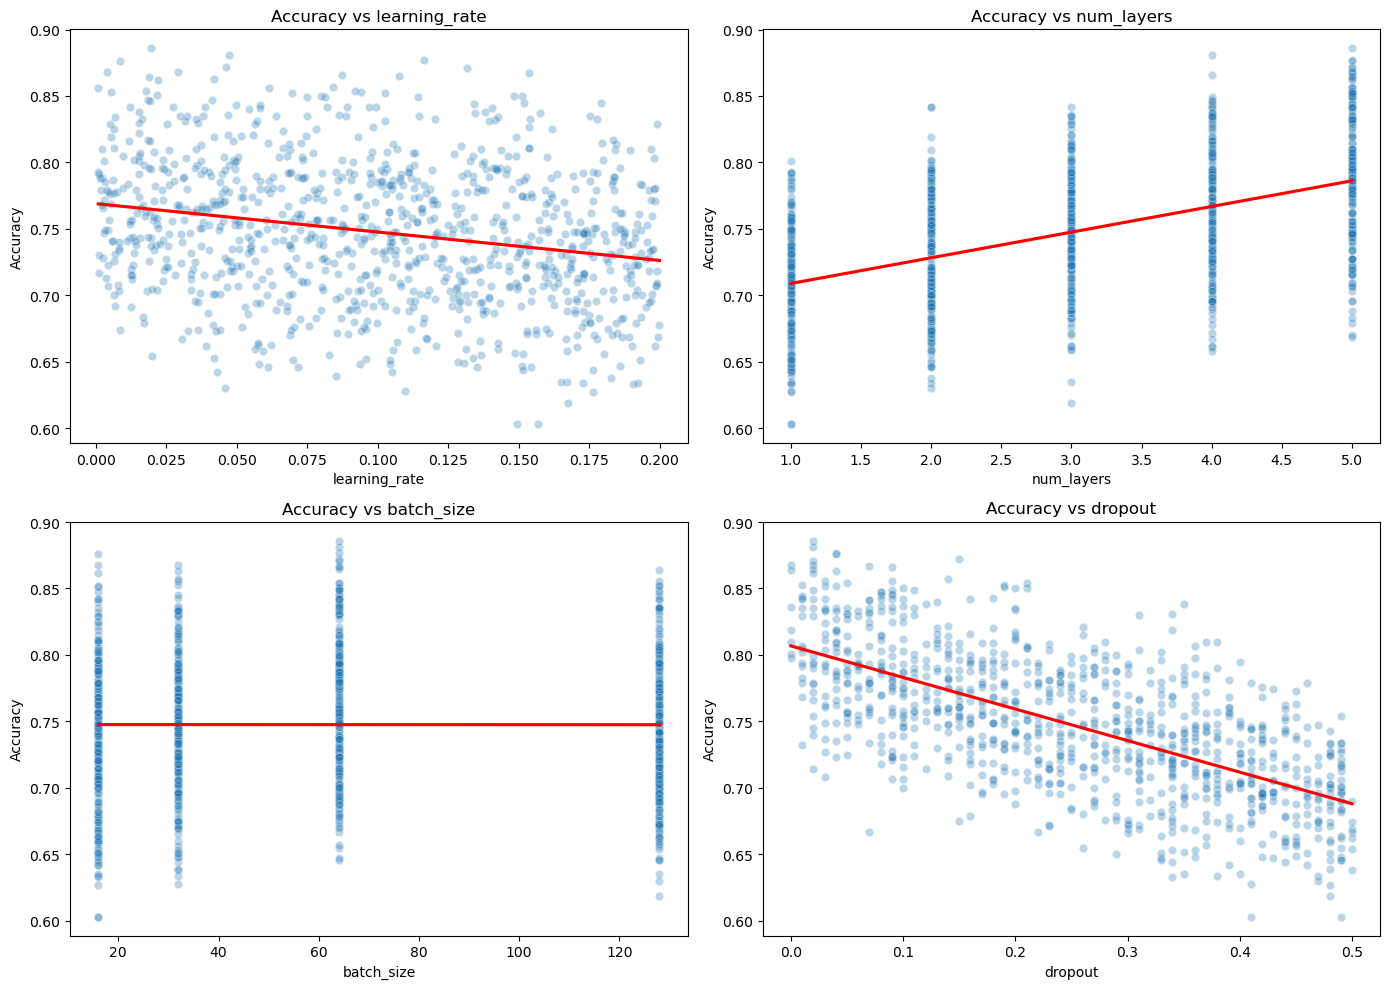

In [6]:
plt.figure(figsize=(14, 10))

features = ['learning_rate', 'num_layers', 'batch_size', 'dropout']

for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=df[col], y=df['accuracy'], alpha=0.3)
    sns.regplot(x=df[col], y=df['accuracy'], scatter=False, color='red', ci=None)
    plt.title(f'Accuracy vs {col}')
    plt.xlabel(col)
    plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

## 📌 Observations — Accuracy vs Hyperparameters

- **Learning Rate**: As learning rate increases, accuracy declines slowly. The effect is mild but consistent — higher learning rates slightly harm performance.

- **Num Layers**: Accuracy improves steadily with more layers, suggesting deeper models learn better representations. This feature has one of the strongest positive correlations with accuracy.

- **Dropout**: Accuracy decreases noticeably as dropout increases. A small dropout (e.g., 0.1–0.2) is optimal; beyond that, accuracy suffers, likely due to underfitting.

- **Batch Size**: Accuracy is largely unaffected by batch size — the trend is flat. This suggests batch size has little predictive power for final performance in this setup.

---
# Phase 3: Machine Learning Models

In this final phase, we use ML models to predict:
1. Whether an experiment will succeed (`success`: classification)
2. What its final accuracy will be (`accuracy`: regression)

In this phase, we build ML models that learn how different hyperparameters affect the outcome of ML experiments — helping us predict both success and accuracy based on their values.


## 🧪 Classification Model: Logistic Regression

- Goal: Predict if an experiment will succeed (`success = 1`) or fail (`success = 0`)
- Features: learning rate, number of layers, dropout, batch size
- Model: Logistic Regression (after standardization)
- Metric: Accuracy + Confusion Matrix


## 📈 Regression Model: Random Forest

- Goal: Predict the final model accuracy given hyperparameters
- Features: Same as above
- Model: Random Forest Regressor
- Metrics: Mean Squared Error (MSE), R² Score, Actual vs Predicted Plot


> This phase shows how even **synthetic, well-designed data** can train accurate models and yield valuable intuition about how different hyperparameters influence ML performance.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
#Features and targets
features = ['learning_rate', 'num_layers', 'batch_size', 'dropout']

X = df[features]
y_class = df['success']      # for classification
y_reg = df['accuracy']       # for regression

# Train-test split
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
_, _, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

📈 Classification Accuracy: 0.790


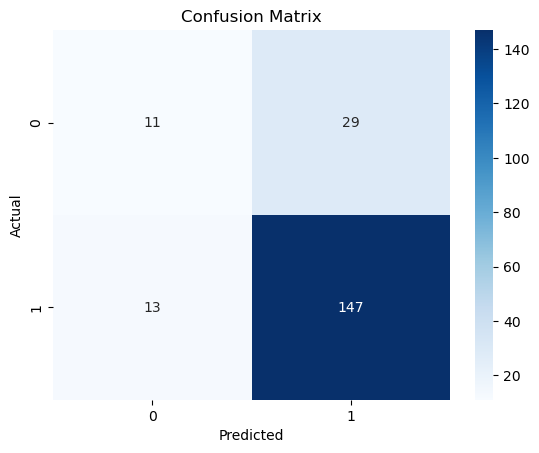

In [9]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train_class)

# Predict
y_pred_class = clf.predict(X_test_scaled)

# Evaluation
acc = accuracy_score(y_test_class, y_pred_class)
cm = confusion_matrix(y_test_class, y_pred_class)

print(f"📈 Classification Accuracy: {acc:.3f}")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

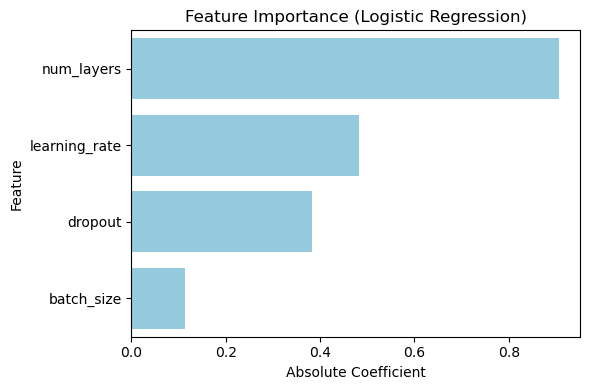

In [10]:
# --- Feature Importance for Logistic Regression ---
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(clf.coef_[0])
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue')
plt.title("Feature Importance (Logistic Regression)")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

📊 Mean Squared Error: 0.0005
🧠 R² Score: 0.803


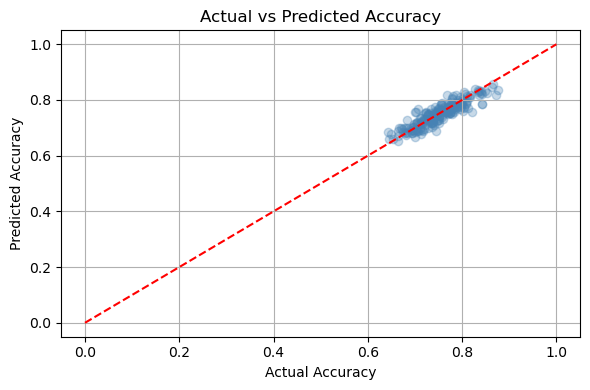

In [11]:
# Tuned Random Forest
reg = RandomForestRegressor(n_estimators=500, max_depth=15, random_state=42)
reg.fit(X_train, y_train_reg)


y_pred_reg = reg.predict(X_test)


mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"📊 Mean Squared Error: {mse:.4f}")
print(f"🧠 R² Score: {r2:.3f}")

plt.figure(figsize=(6, 4))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3, color='steelblue')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual Accuracy")
plt.ylabel("Predicted Accuracy")
plt.title("Actual vs Predicted Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

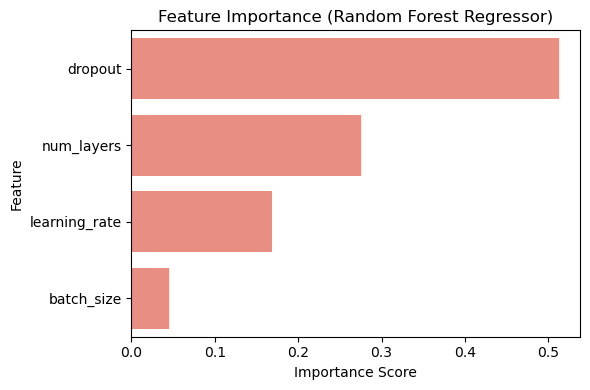

In [12]:
# --- Feature Importance for Random Forest Regressor ---
rf_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': reg.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df, color='salmon')
plt.title("Feature Importance (Random Forest Regressor)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

---
### 🔍 Key Insights from Feature Importance

- **Success Prediction** (Logistic Regression):
  - The number of layers was the most influential factor in determining experiment success.
  - Dropout and learning rate had moderate influence.
  - Batch size showed little predictive power.

- **Accuracy Prediction** (Random Forest):
  - Learning rate and dropout rate were the most important features influencing final model accuracy.
  - Random Forest captured more complex patterns than linear models.

## Final Summary

**Goal**: Predict the success and accuracy of simulated machine learning experiments based on hyperparameters.

### Hyperparameters Used:
- **learning_rate**: Controls model update speed
- **num_layers**: Depth of the neural network
- **batch_size**: Number of samples per update step
- **dropout**: Regularization to prevent overfitting

---
## Results

### Classification Task (Predicting Success)
- **Model**: Logistic Regression
- **Accuracy**: **0.790**
- **Success Distribution**: 74.2% successful experiments

---

### Regression Task (Predicting Accuracy)
- **Model**: Random Forest Regressor (tuned)
- **Mean Squared Error (MSE)**: **0.0005**
- **R^2 Score**: **0.803**

---

### Insights:
- Dropout and learning rate were most influential.
- Regression performance improved after refining the accuracy formula.
- The simulation pipeline successfully mimics real-world ML experimentation.

---
### What I Learned
- How to simulate structured experimental data
- How to model and predict both classification and regression targets
- The connection between hyperparameter tuning and statistical modeling